# Data Cleaning Notebook

This notebook consist of all of the steps we took to transform our raw data into the analysis ready dataset that we use in our final notebook. 

We used three different datasets in our project: 
1. **Citibike Trip Data**
2. **Citibike Station Data**
3. **NYC Race and Income Data**

Thus this notebook is broken up into three parts, one for each dataset.
<br>

_______________

## 1) Citibike Trip Dataset

We collected our 2017 citibike trip data from https://s3.amazonaws.com/tripdata/index.html . 
Our Citibike Trip data cleaning consisted of 2 steps.

#### Part 1.  Cleaning Raw Trip data by Month

- We divided the 12 months into 3 groups and analyzed 4 months each. In this step, we added the geoid to the citibike month data.
- How we divided the months: [Jan - April], [May- August], [Sep- December]
- We also dropped the columns : 
[ 'start station latitude','start station longitude','end station latitude', 'end station longitude', 'bikeid'] 

#### Part 2.  Combining the Months Together

In this step we combined all the trip data together and cleaned up the data using the steps described below: 

1. Filtering mistakes we made in the Part 1 Process (Cleaning Raw Trip data by Month)

2. Combinined all the Months together

3. Coverting starttime+ stoptime to datetime objects 

4. User Filtering to Include only Subscribers

5. Dropping rows where start and end stations are the same 

6. Dropping rows where trip durations exceed 3 hours

7. Checking Missing values in columns

### Part 1 - Cleaning Raw Trip data by Month

Since the code we used to clean the data is mostly the same, 
**we will display the june cleaning as a representive for the initial process of the cleaning data.**

In [1]:
import pandas as pd 
import numpy as np
import requests
import urllib
import matplotlib.pyplot as plt 
import datetime as dt

### June

In [12]:
june_raw = pd.read_csv('./201706-citibike-tripdata.csv')

In [41]:
june_raw.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

#### Read Stations csv file

In [42]:
st_geo_id = pd.read_csv('../citbike stations/citibike_stations_geoid.csv')
st_geo_id.head()

,Unnamed: 0,id,name,lat,lon,first,last,rides,geoid
0,0,254.0,W 11 St & 6 Ave,40.735324,-73.998004,2013-06-01,2019-07-31,168076,36061006300
1,1,151.0,Cleveland Pl & Spring St,40.721816,-73.997203,2013-06-01,2019-07-31,445639,36061004100
2,2,352.0,W 56 St & 6 Ave,40.763406,-73.977225,2013-06-01,2016-12-31,122203,36061010400
3,3,490.0,8 Ave & W 33 St,40.751551,-73.993934,2013-06-01,2019-07-31,480463,36061010300
4,4,236.0,St Marks Pl & 2 Ave,40.728419,-73.987140,2013-06-01,2019-07-31,292217,36061003800


We are calling in the station_geo_id data to join the geo id from the station data to raw may data

In [43]:
# Matching the geoids to the start station ID 
new_data = june_raw.join(st_geo_id.set_index(['id']), on=['start station id'], how='left').copy()

# Changing the column to start station geo ID
new_data.rename(columns = {'geoid': 'start_station_geoid'}, inplace = True)

# Dropping the columns carried over from station ID
new_data = new_data.drop(['Unnamed: 0', 'name', 'lat', 'lon', 'first', 'last', 'rides'], axis = 1).copy()

# Matching the geoids to the end station ID
new_data = new_data.join(st_geo_id.set_index(['id']), on=['end station id'], how='left').copy()
new_data = new_data.drop(['Unnamed: 0', 'name', 'lat', 'lon', 'first', 'last', 'rides'], axis = 1).copy()
new_data.rename(columns = {'geoid': 'end_station_geoid'}, inplace = True)

# Making all columns lower case
new_data.columns = map(str.lower, new_data.columns)

# Dropping columns we're not going to use
new_data = new_data.drop(['start station latitude','start station longitude','end station latitude', 'end station longitude', 'bikeid'], axis = 1).copy()
new_data.shape

(1523268, 12)

In [45]:
june_final = new_data
june_final.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'end station id', 'end station name', 'usertype',
       'birth year', 'gender', 'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [51]:
june_final.head()

,tripduration,starttime,stoptime,start station id,start station name,end station id,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid
0,1397,2017-06-01 00:00:02,2017-06-01 00:23:19,515,W 43 St & 10 Ave,3285,W 87 St & Amsterdam Ave,Subscriber,1967.0,1,3.606101e+10,3.606102e+10
1,1103,2017-06-01 00:00:13,2017-06-01 00:18:37,488,W 39 St & 9 Ave,297,E 15 St & 3 Ave,Subscriber,1981.0,1,3.606101e+10,3.606100e+10
2,1810,2017-06-01 00:00:20,2017-06-01 00:30:31,461,E 20 St & 2 Ave,465,Broadway & W 41 St,Subscriber,1982.0,1,3.606101e+10,3.606101e+10
3,1760,2017-06-01 00:00:24,2017-06-01 00:29:45,2009,Catherine St & Monroe St,527,E 33 St & 2 Ave,Subscriber,1973.0,2,3.606100e+10,3.606101e+10
4,2165,2017-06-01 00:00:33,2017-06-01 00:36:38,360,William St & Pine St,474,5 Ave & E 29 St,Subscriber,1985.0,1,3.606100e+10,3.606101e+10


#### Save to csv

In [46]:
june_final = june_final.to_csv('./june_final.csv')

**For this step we repeated this process for all the 12 months.**

### Part 2. Combining the citibike data by month


In this step, we called in all the citibike data by month and combined the 12 months together

In [71]:
# call in all the citibike data by month
jan_raw = pd.read_csv('./final/jan_final.csv')
feb_raw = pd.read_csv('./final/feb_final.csv')
march_raw = pd.read_csv('./final/march_final.csv')
april_raw = pd.read_csv('./final/april_final.csv')
may_raw = pd.read_csv('./final/may_final.csv')
june_raw = pd.read_csv('./final/june_final.csv')
july_raw = pd.read_csv('./final/july_final.csv')
august_raw = pd.read_csv('./final/august_final.csv')
sep_raw = pd.read_csv('./final/sep.csv')
oct_raw = pd.read_csv('./final/oct.csv')
nov_raw = pd.read_csv('./final/nov.csv')
dec_raw = pd.read_csv('./final/dec.csv')

#### 1. Filtering mistakes we made in the Part 1 Process (Cleaning Raw Trip data by Month)

##### Checking we did the separate data cleaning process identically

In [81]:
#looking at the columns for jan-april group jan representative
jan_raw.columns

Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start station id', 'start station name', 'end station id',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [82]:
#looking at the columns for may-august group may representative
may_raw.columns

Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start station id', 'start station name', 'end station id',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [83]:
#looking at the columns for sep-dec group December representative
dec_raw.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station name',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')



<br/>

**Different Column Names Found**

For Jan - April the columns are named ['start time' 'stop time' 'trip duration''user type'] while for May-Dec the columns are named ['starttime' 'stoptime''tripduration''usertype'].
I will clean the Jan-April data so that the columns are ['starttime' 'stoptime' 'tripduration'' usertype'].  
(Without the space in between)

In [84]:
# renaming the columns for jan-april months
jan_raw = jan_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

In [85]:
feb_raw = feb_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

In [86]:
march_raw = march_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

In [87]:
april_raw = april_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

<br/>

#### 2. Combine all the months together

In this step we will combine all of the citibike trip data together. 
We cleaned and added geoid data of 4months each. 

In [88]:
# concatenating the list of dataframes together
frames = [jan_raw,feb_raw, march_raw, april_raw, may_raw, june_raw ,july_raw,august_raw ,sep_raw ,oct_raw,nov_raw,dec_raw]
result = pd.concat(frames,ignore_index=True)

In [89]:
result.columns

Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start station id', 'start station name', 'end station id',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [93]:
# printing out random rows in the result data
#sep-dec months
result.loc[10790070]

Unnamed: 0                                     NaN
tripduration                                   881
starttime                      2017-09-29 07:56:25
stoptime                       2017-09-29 08:11:06
start station id                               NaN
start station name           Pershing Square South
end station id                                 NaN
end station name       Greenwich St & W Houston St
usertype                                Subscriber
birth year                                    1966
gender                                           1
start_station_geoid                     3.6061e+10
end_station_geoid                       3.6061e+10
Name: 10790070, dtype: object

In [91]:
#may-august months
result.loc[8790090]

Unnamed: 0                            238237
tripduration                            1004
starttime                2017-08-04 19:59:25
stoptime                 2017-08-04 20:16:09
start station id                         284
start station name     Greenwich Ave & 8 Ave
end station id                           426
end station name       West St & Chambers St
usertype                            Customer
birth year                               NaN
gender                                     0
start_station_geoid               3.6061e+10
end_station_geoid                 3.6061e+10
Name: 8790090, dtype: object

In [92]:
#jan-april months
result.loc[100091]

Unnamed: 0                          100091
tripduration                           737
starttime              2017-01-05 21:06:47
stoptime               2017-01-05 21:19:04
start station id                       280
start station name         E 10 St & 5 Ave
end station id                         394
end station name         E 9 St & Avenue C
usertype                        Subscriber
birth year                            1961
gender                                   2
start_station_geoid             3.6061e+10
end_station_geoid               3.6061e+10
Name: 100091, dtype: object


<br/>

**Additional Start/End Stations Removed for Sep-Dec**

Because we did the data cleaning separately, we made a mistake in removing the start, end station ids . 

For months in September- December we don't have the the start and end station ids.

Fortunately we won't be using them for this project. So we will drop these columns

Checking out random rows like this makes sense because we divided the months by 4 months each and checking one month within the ranges would be representative of how that person did the data cleaning for the respective 4 months

#### Drop start,end station ids

Dropping the start,end station id errors we made in the previous process

In [97]:
result = result.drop(['start station id','end station id'], axis = 1).copy()

#### Save to csv
Saving the csv file and uploading to google drive so we can use for later

In [99]:
final_trip_data = result.to_csv('./final_trip_data.csv')

#### Additional Data Cleaning

After starting the data exploration we realized we needed to comeback and do addtional data cleaning.
We will be using this final cleaned data in our exploration process


In [2]:
df = pd.read_csv('../../data_exploration/final_trip_data.csv')

In [3]:
df.dtypes

Unnamed: 0               int64
Unnamed: 0.1           float64
tripduration             int64
starttime               object
stoptime                object
start station name      object
end station name        object
usertype                object
birth year             float64
gender                   int64
start_station_geoid    float64
end_station_geoid      float64
dtype: object

<br/>

#### 3. Convert to datetime objects

We will be converting the starttime and stoptime columns to datetime objects

In [3]:
df['starttime']=pd.to_datetime(df['starttime'], format='%Y-%m-%d %H:%M:%S')

In [4]:
df['stoptime']=pd.to_datetime(df['stoptime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
df.dtypes

Unnamed: 0                      int64
Unnamed: 0.1                  float64
tripduration                    int64
starttime              datetime64[ns]
stoptime               datetime64[ns]
start station name             object
end station name               object
usertype                       object
birth year                    float64
gender                          int64
start_station_geoid           float64
end_station_geoid             float64
dtype: object

<br/>

#### 4. User Filtering

Though many Citi Bike customers that are (1-day pass or 3-day pass) are often tourists and may not put in their birth year in a rush or due to other reasons. Also there are some Nan values for usertypes so we will be dropping those too

In [6]:
df['usertype'].unique()

array(['Subscriber', 'Customer', nan], dtype=object)

In [7]:
#getting dataframe usertypes for Subscribers only
df= df.loc[df['usertype']=='Subscriber']

In [8]:
df['usertype'].unique()

array(['Subscriber'], dtype=object)

In [9]:
df.shape

(14578993, 12)

<br/>

#### 5. Drop rows where start station and end stations are the same

Citi Bike riders often come across broken bikes. We will drop any trips where the start station = end station. This is an arbitrary choice based on how long it would take a rider to realize a bike isn’t working properly and coming back to the station to return it and take a new on. 

When the start station = end station we assumed that there would probably we a majority of cases where people where having trouble with using citibike in the inital process.

In [10]:
df= df.loc[df['start station name']!= df['end station name']]

In [11]:
df.shape

(14367769, 12)

In [12]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'tripduration', 'starttime', 'stoptime',
       'start station name', 'end station name', 'usertype', 'birth year',
       'gender', 'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [13]:
#drop columns that were added in this process by default
df=df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,tripduration,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10
8,255,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10


<br/>

#### 6. Check max Trip Duration

In [14]:
max=df['tripduration'].max()
max

9735948

In [15]:
dfd= df.loc[df['tripduration']==9735948]
dfd

,tripduration,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid
2313658,9735948,2017-04-03 07:50:27,2017-07-25 00:16:16,Fulton St & Rockwell Pl,NYCBS Depot - GOW,Subscriber,1983.0,1,3.604700e+10,3.604701e+10


The tripduration is in seconds so the max trip lasted 9735948/60 which is 162265.8 minutes which is 2704 hours, an unreasonable amount of time. This kind of data could result from a lost bike or a stolen one that was not reported. In 2017 for subscribers, 45minutes of unlimited citibike use was allowed. Sp we decided to include citibike data that was only used for under 3 hours. For additional hours of citibike usage, citibike charged its users $0.18 dollars for each additional minute.

**If you keep a bike out for longer than 30 minutes at a time, regardless of the type, it's $0.18 per minute.**
--According to citibike website in 2017 (https://www.citibikenyc.com/pricing/single-ride)

Therefore using a citibike for unreasonably long hours of time even if you are a subscriber would be unreasonable since you are being charged. 
For this analysis we decided to set 3hours as the limit to a reasonable amount of time a person uses a citibike. 

In [16]:
## drop trip durations over 3hours
df= df.loc[df['tripduration']<10800]
max=df['tripduration'].max()
max

10798

In [17]:
df.shape

(14356739, 10)

**Deleting Trip Duration Column and adding Trip Minutes Column**

For data analysis, we concluded that looking at trip durations in minutes instead of seconds was a better way to understand the data and easier to explain. We create a column in the data frame called trip minutes. We will delete the trip duration

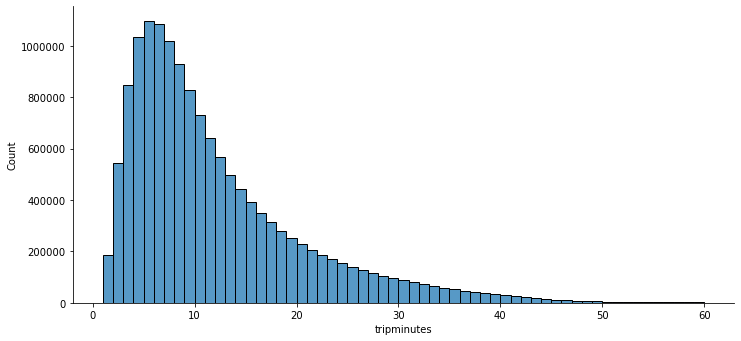

In [18]:
#create a plot to understand the trip duration
df['tripminutes'] = df['tripduration'] // 60
sns.displot(data=df,x="tripminutes", bins=range(1,61), aspect=10/5);
plt.ticklabel_format(style='plain', axis='y')

In [19]:
#drop trip duration column
df=df.drop(columns=['tripduration'])

In [20]:
df.head()

,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21
6,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10,9
7,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10,13
8,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10,4


Our final data now looks like this with columns: 

[starttime, stoptime, startstationname, endstationname, usertype, birthyear, gender, start_station_geoid, end_station_geoid, tripminutes]

<br/>

#### 7. Check rows of Column values that are missing

In [22]:
(df['start station name']== None).unique()

array([False])

In [23]:
(df['end station name']== None).unique()

array([False])

In [24]:
(df['gender']== None).unique()

array([False])

In [25]:
(df['birth year']== None).unique()

array([False])

In [26]:
(df['starttime']== None).unique()

array([False])

In [27]:
(df['stoptime']== None).unique()

array([False])

There seems to be no missing values

### Save final data to csv

In [29]:
final_trip_data = df.to_csv('./clean_trip_data.csv')

Because the bike data is extracted from Citibike, we didn't have to deal with any weird occurences like strings in a column that should have integers. The main issues that we had to deal with in the data were due to human interactions with the bikes and machine recording errors. We decided to filter on only subscribers since subscribers are more likely to live physically in NYC rather than visiting. More specifically, for our purpose of studying station and trip data, we felt that this was an appropriate level of data cleaning for our purposes.
<br> 

________________

## 2) Citibike Stations Dataset 

We downloaded the raw station data from an [MIT study that created data for stations](https://github.com/aberke/income-race-bikes) from citibike trip data  which contained all of the citbike data. The first thing we did was to delete the row with latitidue = 45.506264191001186, since this station is not located in NYC. Perhaps it was a data entry error from Citibike. But this is not a concern as it is only one row out of a total of almost 1000 rows. 

In [84]:
#This is a table containing all of the stations owned by citibike in NYC. 
stations = pd.read_csv('stations.csv')
stations = stations[stations['lat'] != 45.506264191001186] 
#remove this station since it is located in canada not NYC.
#45.506264191001186, -73.56890559196472

In [85]:
#This gets the (lat,lon) of all of the citibike stations in NYC 
stations_lat = list(stations['lat'])
stations_lon = list(stations['lon'])
stations_lat_lon = [(stations_lat[i],stations_lon[i]) for i in range(len(stations_lat))]

To obtain the geoid which is the unique identifier of the census tract that the station is located in, I used the following online API. 

In [88]:
#This uses a freely available goverment API that allows us to get the geoid based on the (lat,lon) of each citibike sttaion.
station_geoid = []
for lat, lon in stations_lat_lon: 
    #Encode parameters 
    params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()

    #Print FIPS code
    returned_FIPS = (data['Block']['FIPS'])
    geoid = returned_FIPS[:11] 
    station_geoid.append(geoid)

In [89]:
stations_geoid = [int(geoid) for geoid in station_geoid]

In [91]:
#add the geoid column to the stations table
stations['geoid'] = stations_geoid

Here I rename some columns to make their names more intuitive and also remove all stations made after 2017, as we are going to base our analysis on the year 2017, so any Citibike stations made after it is irrelevant

In [10]:
stations = stations.drop('Unnamed: 0',axis=1)
stations.rename(columns={'id':'station_id', 'name':'station_name','first':'first_trip','last':'last_trip'},inplace=True)
stations['first_trip'] = pd.to_datetime(stations['first_trip'])
stations['last_trip'] = pd.to_datetime(stations['last_trip'])
#only select stations made during or before 2017 
stations = stations[stations['first_trip'] <= datetime.datetime(2017,12,30)]

In [13]:
stations_geoid.to_csv('citibike_stations_geoid_final.csv',index=False)

For this data set, we mainly had to deal with using the API and configuring the data so that it would be usable for the whole team. Because this data set is mainly used as a reference for connecting our trip data and race, income data, we felt this was an appropriate level of data cleaning.

## 3) Race and Income Dataset 

I downloaded the raw race and income data from the  and performed the following operations to clean it up. 

In [2]:
race_and_income = pd.read_csv('race_and_income_data.csv')

#### 1. Extracting year 2017 only

Since our project will be focusing on the year 2017, we only require the race and income data from that year

In [3]:
#only interested in 2017 data 
race_and_income = race_and_income[['geoid','2017 median income','2017 median income margin of error', 
     '2017 race: total households', '2017 race: total households margin of error', '2017 race: White',
    '2017 race: Black', '2017 race: Asian', '2017 race: Other', '2017 race: 2 or more races']]

#### 2. Data Cleaning of median income values

Removing rows where the median income is not an integer. Also some median income values are '250,000+' and I changed these to '250,000' so that they can be treated as integers. 

In [4]:
#removing rows with non-integer median income values
race_and_income = race_and_income[race_and_income['2017 median income'] != '-']
race_and_income['2017 median income'] = race_and_income['2017 median income'].apply(lambda x: 250000 if x=='250,000+' else x)
race_and_income = race_and_income[race_and_income['2017 median income margin of error'] != '***']
race_and_income = race_and_income.astype({'2017 median income': 'int64', '2017 median income margin of error':'int64'})

In [5]:
race_and_income.to_csv('race_and_income_final.csv',index=False)

Since this dataset was extracted from the American Survey Community's portal, the dataset didn't have any strange occurences that we had to account for. Therefore, we felt this was an appropraite level of data cleaning for this data set. 